In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of sRNA in mRNA targetting

## Imports

In [2]:
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from subprocess import Popen, PIPE, run
from datetime import datetime
import pandas as pd

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax



# Load data

In [3]:
fn_RNAInter = os.path.join('..', 'data', 'sRNA', 'RNAInter', 'Download_data_RR.csv')
data = pd.read_csv(fn_RNAInter)
try:
    data = data.drop(columns=['Unnamed: 0'])
except:
    pass


In [6]:
print(data.iloc[0]['Sequence1'], '\n',
data.iloc[0]['Sequence2'])

ATTCGGAACGAGGCCTGAAGCAGTGTCGCCGTCCCTCTGCCTTGCACAAAAAGCACAAGCATTCCTTAGCAGCTCAGGCGCACCTANGTGGGAGCCCAGCACACTGCTTCTCGGAGGCCAGGCCCTCCTGCTGGCTGAGGCTTGGGCCCAGTAGCCCCAATATGGTGGCCCTGGGGAAGAGGCCTTGGGGGTCTGCTCTGTGCCTGGGATCAGTGGGGNCCCAAANGCCAGCCCTNCTGANCAACATTNAAAATGNACAAAACCTNGGGGACTTTTGNTTTTGNTTTTNCCCTT 
 TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCATCCCAGACCTCTTCTGTCGCTCAGATCATCGATATCCGCTCTGACAAGAAGGATGTCGAGCTGCGCGTGTCTCTCCAGCAGAGCATCCACAGCGACGACGCCGCGCTGCCCGATCTGCTCCTCTGGGATGAACAGGGGCTGCGCTATTTTGAGGATGTTACCTACTGCCCATCGTACTATTTAACGAGGGAGGAAATTGGTCTGTTGAAGAAATACAGCCTGCAAATCGCCGAACACATCCAGCCGGGCAGCATGCTGGTCGAGCTGGGGAGCGGAAACCTCCGCAAGACGAAGATTCTGCTGGATGCGCTCGAGGAGCTAGGTCGGCCGGTAGACTATTTCGCCCTCGACGTCTCCTACCCTGAGCTCAAGCGCACACTCCGCCCCGTCGGGGCGGGCGTCTACCAGCACGTCCGCTGCTATGGGCTGCTGGGCACCTATGACG


In [18]:
print(len(data))
nn = np.sum(np.arange(1, len(data)+1)) + len(data)
print('Expected number of species: ', nn)
data.head()

354
Expected number of species:  63189


,index,RNAInterID,Interactor1.Symbol,Category1,Species1,Interactor2.Symbol,Category2,Species2,Raw_ID1,Raw_ID2,score,strong,weak,predict,Sequence1,Sequence2
0,1029724,RR05384747,acnA,mRNA,Escherichia coli str. K-12 substr. MG1655,ryhB,sRNA,Escherichia coli str. K-12 substr. MG1655,NCBI:946724,NCBI:2847761,0.2292,Northern blot//Reporter assay,NaN,NaN,ATTCGGAACGAGGCCTGAAGCAGTGTCGCCGTCCCTCTGCCTTGCA...,TTTGAGAGCGTCTCTGTCCCTCGTTTTGCGGTTAAGCCGCATCCAT...
1,1029725,RR05384845,acrZ,mRNA,Escherichia coli str. K-12 substr. MG1655,omrB,sRNA,Escherichia coli str. K-12 substr. MG1655,NCBI:945365,NCBI:2847747,0.1778,Northern blot,Microarray,NaN,ACTTACTACTGTCTTCGGGGGGTCCGAGGTTTCTGGGGGGTCGTAC...,TGTTCTATACTTGGGTTCGACTTGGGTTAGACTTGTCTTTACTGTC...
2,1029732,RR05387056,arcZ,sRNA,Escherichia coli str. K-12 substr. MG1655,flhD,mRNA,Escherichia coli str. K-12 substr. MG1655,NCBI:2847690,NCBI:945442,0.2314,Northern blot//Reporter assay,NaN,NaN,CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...,CTCGTGCCGAATTCGGCACGAGCGATATTTCATCAGTTATCGGTAA...
3,1029733,RR05387057,arcZ,sRNA,Escherichia coli str. K-12 substr. MG1655,rpoS,mRNA,Escherichia coli str. K-12 substr. MG1655,NCBI:2847690,NCBI:947210,0.1996,Northern blot//RACE//RT-PCR//Beta-galactosidas...,NaN,NaN,CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...,ATCCTCGGGTCTTGCAGGCCACACAGGACACCCTGAACCGTCATGG...
4,1029734,RR05387126,argR,mRNA,Escherichia coli str. K-12 substr. MG1655,dsrA,sRNA,Escherichia coli str. K-12 substr. MG1655,NCBI:947861,NCBI:946470,0.2139,Primer extension assay,NaN,NaN,GACAATGGCGATAGTATGGCGGTTGTTTCTTTCCCATCTCTACTCA...,TGAGCAACTTTATTCACATAATTTCTACACCAAGAACTCGAGGTTA...


# Get mRNAs and sRNAs

In [19]:
# srnas = list(set(data[data['Category1'] == 'sRNA']['Interactor1.Symbol'].to_list() + data[data['Category2'] == 'sRNA']['Interactor2.Symbol'].to_list()))
# mrnas = list(set(data[data['Category1'] == 'mRNA']['Interactor1.Symbol'].to_list() + data[data['Category2'] == 'mRNA']['Interactor2.Symbol'].to_list()))

srnas, mrnas = {}, {}
for s in data[data['Category1'] == 'sRNA']['Interactor1.Symbol'].unique():
    srnas[s] = data[data['Interactor1.Symbol'] == s]['Sequence1'].iloc[0]

for s in data[data['Category2'] == 'sRNA']['Interactor2.Symbol'].unique():
    srnas[s] = data[data['Interactor2.Symbol'] == s]['Sequence2'].iloc[0]

for m in data[data['Category1'] == 'mRNA']['Interactor1.Symbol'].unique():
    seq = data[data['Interactor1.Symbol'] == m]['Sequence1'].iloc[0]
    if type(seq) == str:
        mrnas[m] = seq

for m in data[data['Category2'] == 'mRNA']['Interactor2.Symbol'].unique():
    seq = data[data['Interactor2.Symbol'] == m]['Sequence2'].iloc[0]
    if type(seq) == str:
        mrnas[m] = seq

In [20]:
[i for i in mrnas.keys() if i in list(srnas.keys())]

[]

In [21]:

config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data": {},
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "outCsvCols": "id1, id2, E, bpList, E_norm, hybridDPfull",
        "threads": 8,
        "n": 5,
        "raw_stdout": True
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}
data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)


## Create circuits

In [22]:
len(srnas) * len(mrnas)

5180

In [51]:
sim_data = {}

def simulate_IntaRNA_local(query: dict,
                           targets: dict,
                           sim_kwargs={},
                           simulator=IntaRNA()):
    fn1 = data_writer.output(data=query, out_type='fasta', out_name='query', byseq=True, return_path=True)
    fn2 = data_writer.output(data=targets, out_type='fasta', out_name='targets', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn2
    
    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                    '--outMode=C', f'--outcsvcols={outcsvcols}',
                    f'--qIdxPos0={qidxpos0}',
                    f'--tIdxPos0={tidxpos0}',
                    f'--outNumber={n}',
                    f'--threads={threads}', param_file]
                    + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)
    
    return run(**sim_kwargs)


for s, sseq in srnas.items():
    sim_data[s] = {}
    t = datetime.now()

    sim_data[s] = simulate_IntaRNA_local(query={s: sseq},
                                         targets=mrnas,
                                         sim_kwargs=config_file['interaction_simulator']['simulator_kwargs'],
                                         simulator=IntaRNA())
    print('Finished ', s, ' in ', (datetime.now() - t).total_seconds(), ' s')

    data_writer.output(data=sim_data, out_type='json',
                       out_name='inter_data_raw', overwrite=True)

Finished  arcZ  in  54.910919  s
Finished  arrS  in  35.321667  s
Finished  chiX  in  78.424952  s
Finished  cyaR  in  71.926472  s
Finished  dicF  in  48.124806  s
Finished  dsrA  in  67.317026  s
Finished  fnrS  in  40.348168  s


KeyboardInterrupt: 

# Load simulation results

In [ ]:
fn = './data/05_orthogonality_mRNA_official/2023_11_08_145023/inter_data_raw.json'

sim_data_l = load_json_as_dict(fn)


Need to add zeros back in, since IntaRNA just excludes runs where the binding energy is zero kcal.

In [44]:
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = {}
            sim_data_l[s][d]['E'] = 0
            sim_data_l[s][d]['bpList'] = ''
        

In [50]:
energies = pd.DataFrame(data=np.array([[vv['E'] for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

<Figure size 2100x2700 with 0 Axes>

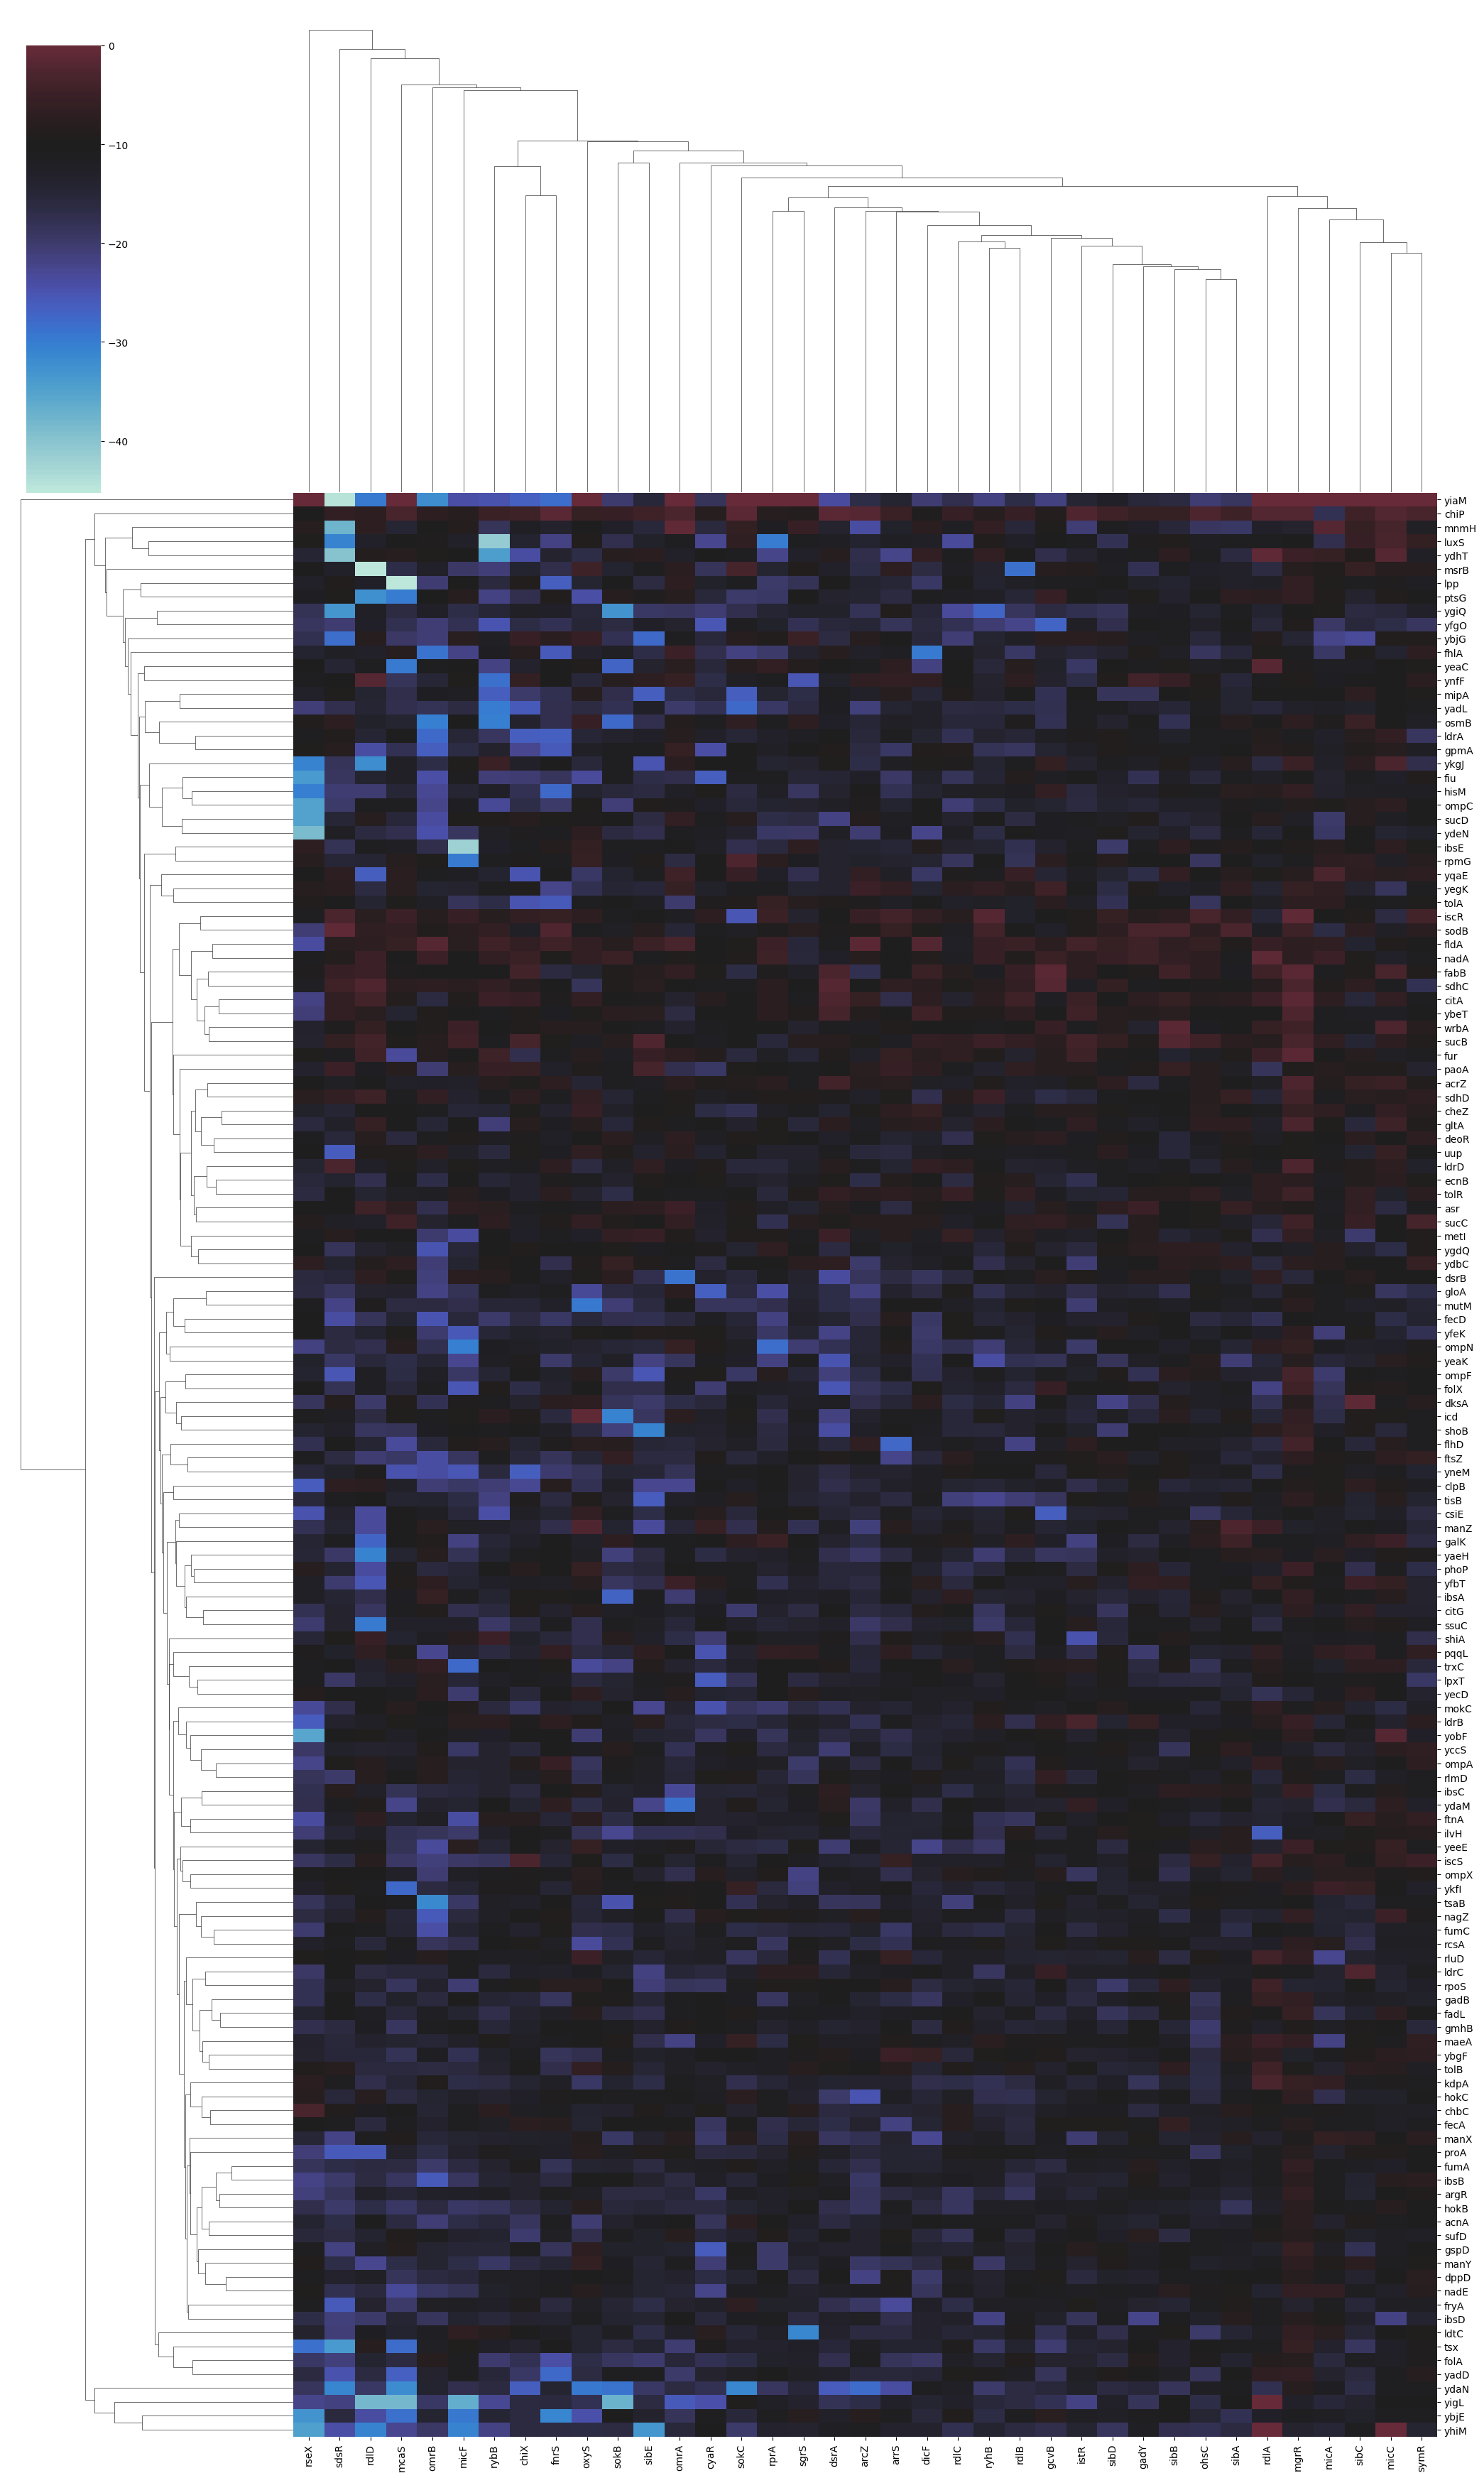

In [84]:
fig = plt.figure(figsize=(21, 27))
sns.clustermap(energies, center=-10, figsize=(21, 35), cmap= 'icefire') # Spectral, cubehelix, vlag
# plt.title('sRNA (bottom) interaction with known mRNA targets (side) binding energies (kcal)')

## Assess specificity

In [117]:
specificity = pd.DataFrame(data=np.zeros_like(np.array([[vv['E'] for vv in v.values()] for v in sim_data_l.values()]).T),
                           columns=list(sim_data_l.keys()), index=list(list(sim_data_l.values())[0].keys()))

for s in data[data['Category1'] == 'sRNA']['Interactor1.Symbol'].unique():
    specificity.loc[list(data[(data['Interactor1.Symbol'] == s) & (data['Category2'] == 'mRNA') & (
        ~data['Sequence2'].isna())]['Interactor2.Symbol'].unique()), s] = 1

Text(0.5, 1.0, 'Officially documented sRNA - mRNA interactions')

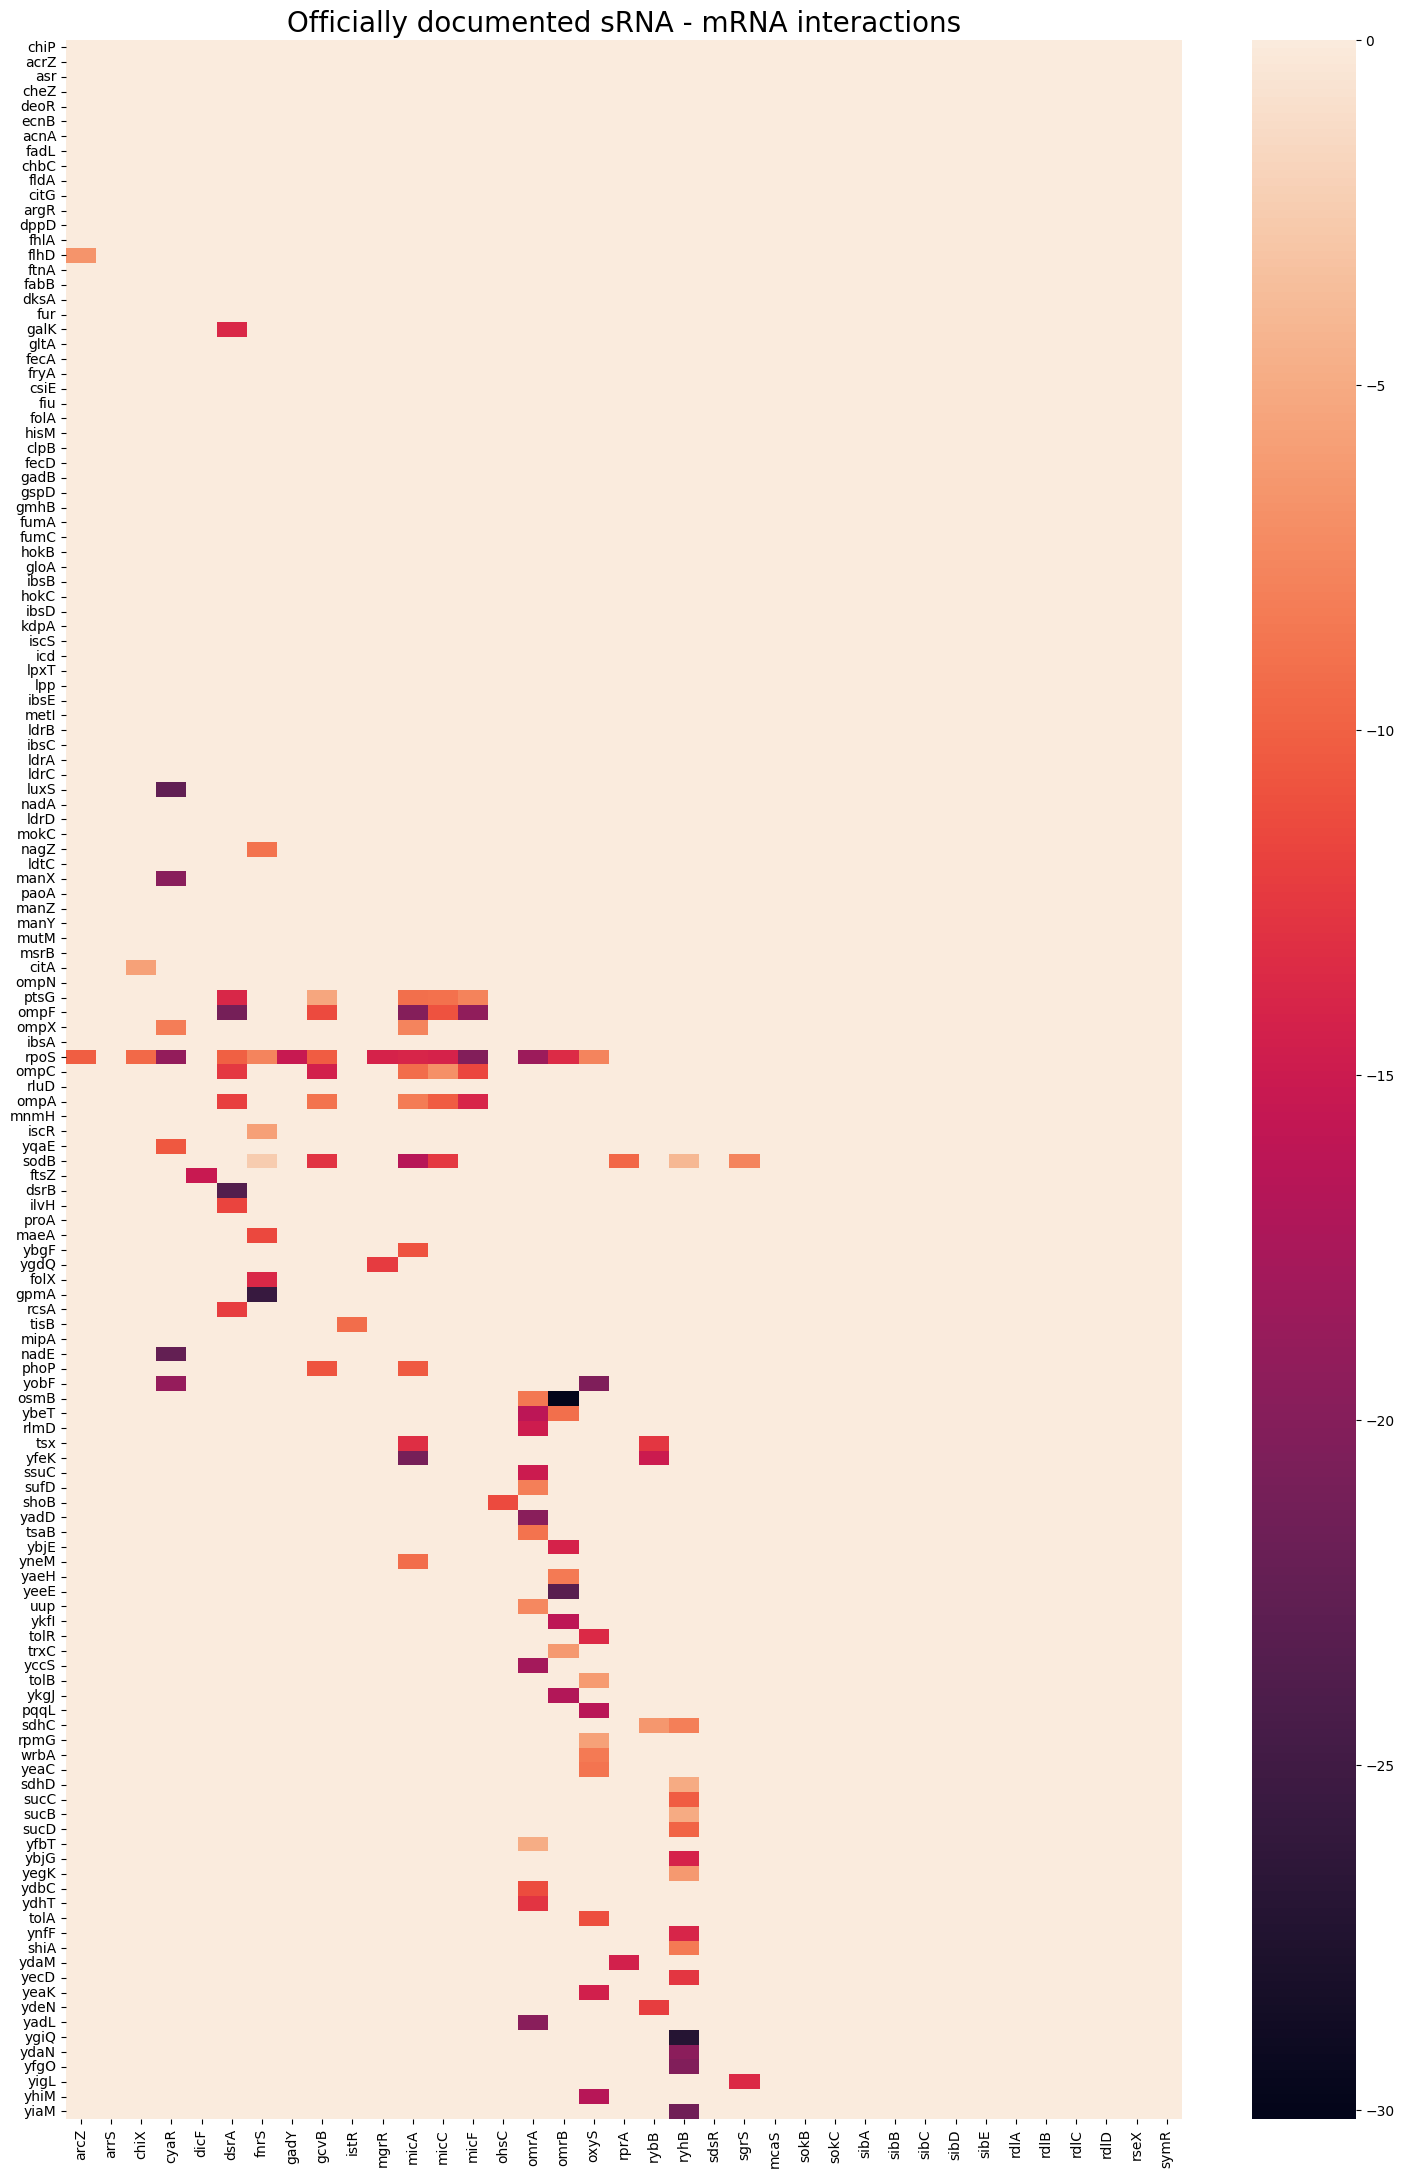

In [126]:
fig = plt.figure(figsize=(18, 27))
sns.heatmap(specificity * energies)
plt.title('Officially documented sRNA - mRNA interactions', fontsize=20)


Text(0, 0.5, 'Average binding energy for all mRNAs per sRNA')

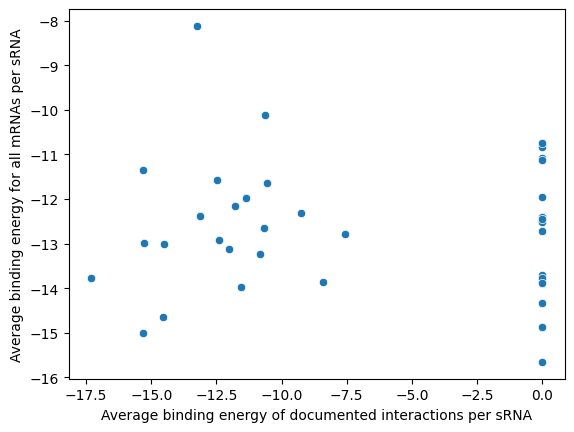

In [145]:
sns.scatterplot(x=(specificity * energies).sum(axis=0) / (np.where(specificity.sum(axis=0) == 0, 1, specificity.sum(axis=0))),
                y=energies.sum(axis=0) / (energies < 0).sum(axis=0))

plt.xlabel('Average binding energy of documented interactions per sRNA')
plt.ylabel('Average binding energy for all mRNAs per sRNA')

Text(0.5, 1.0, 'Documented interaction')

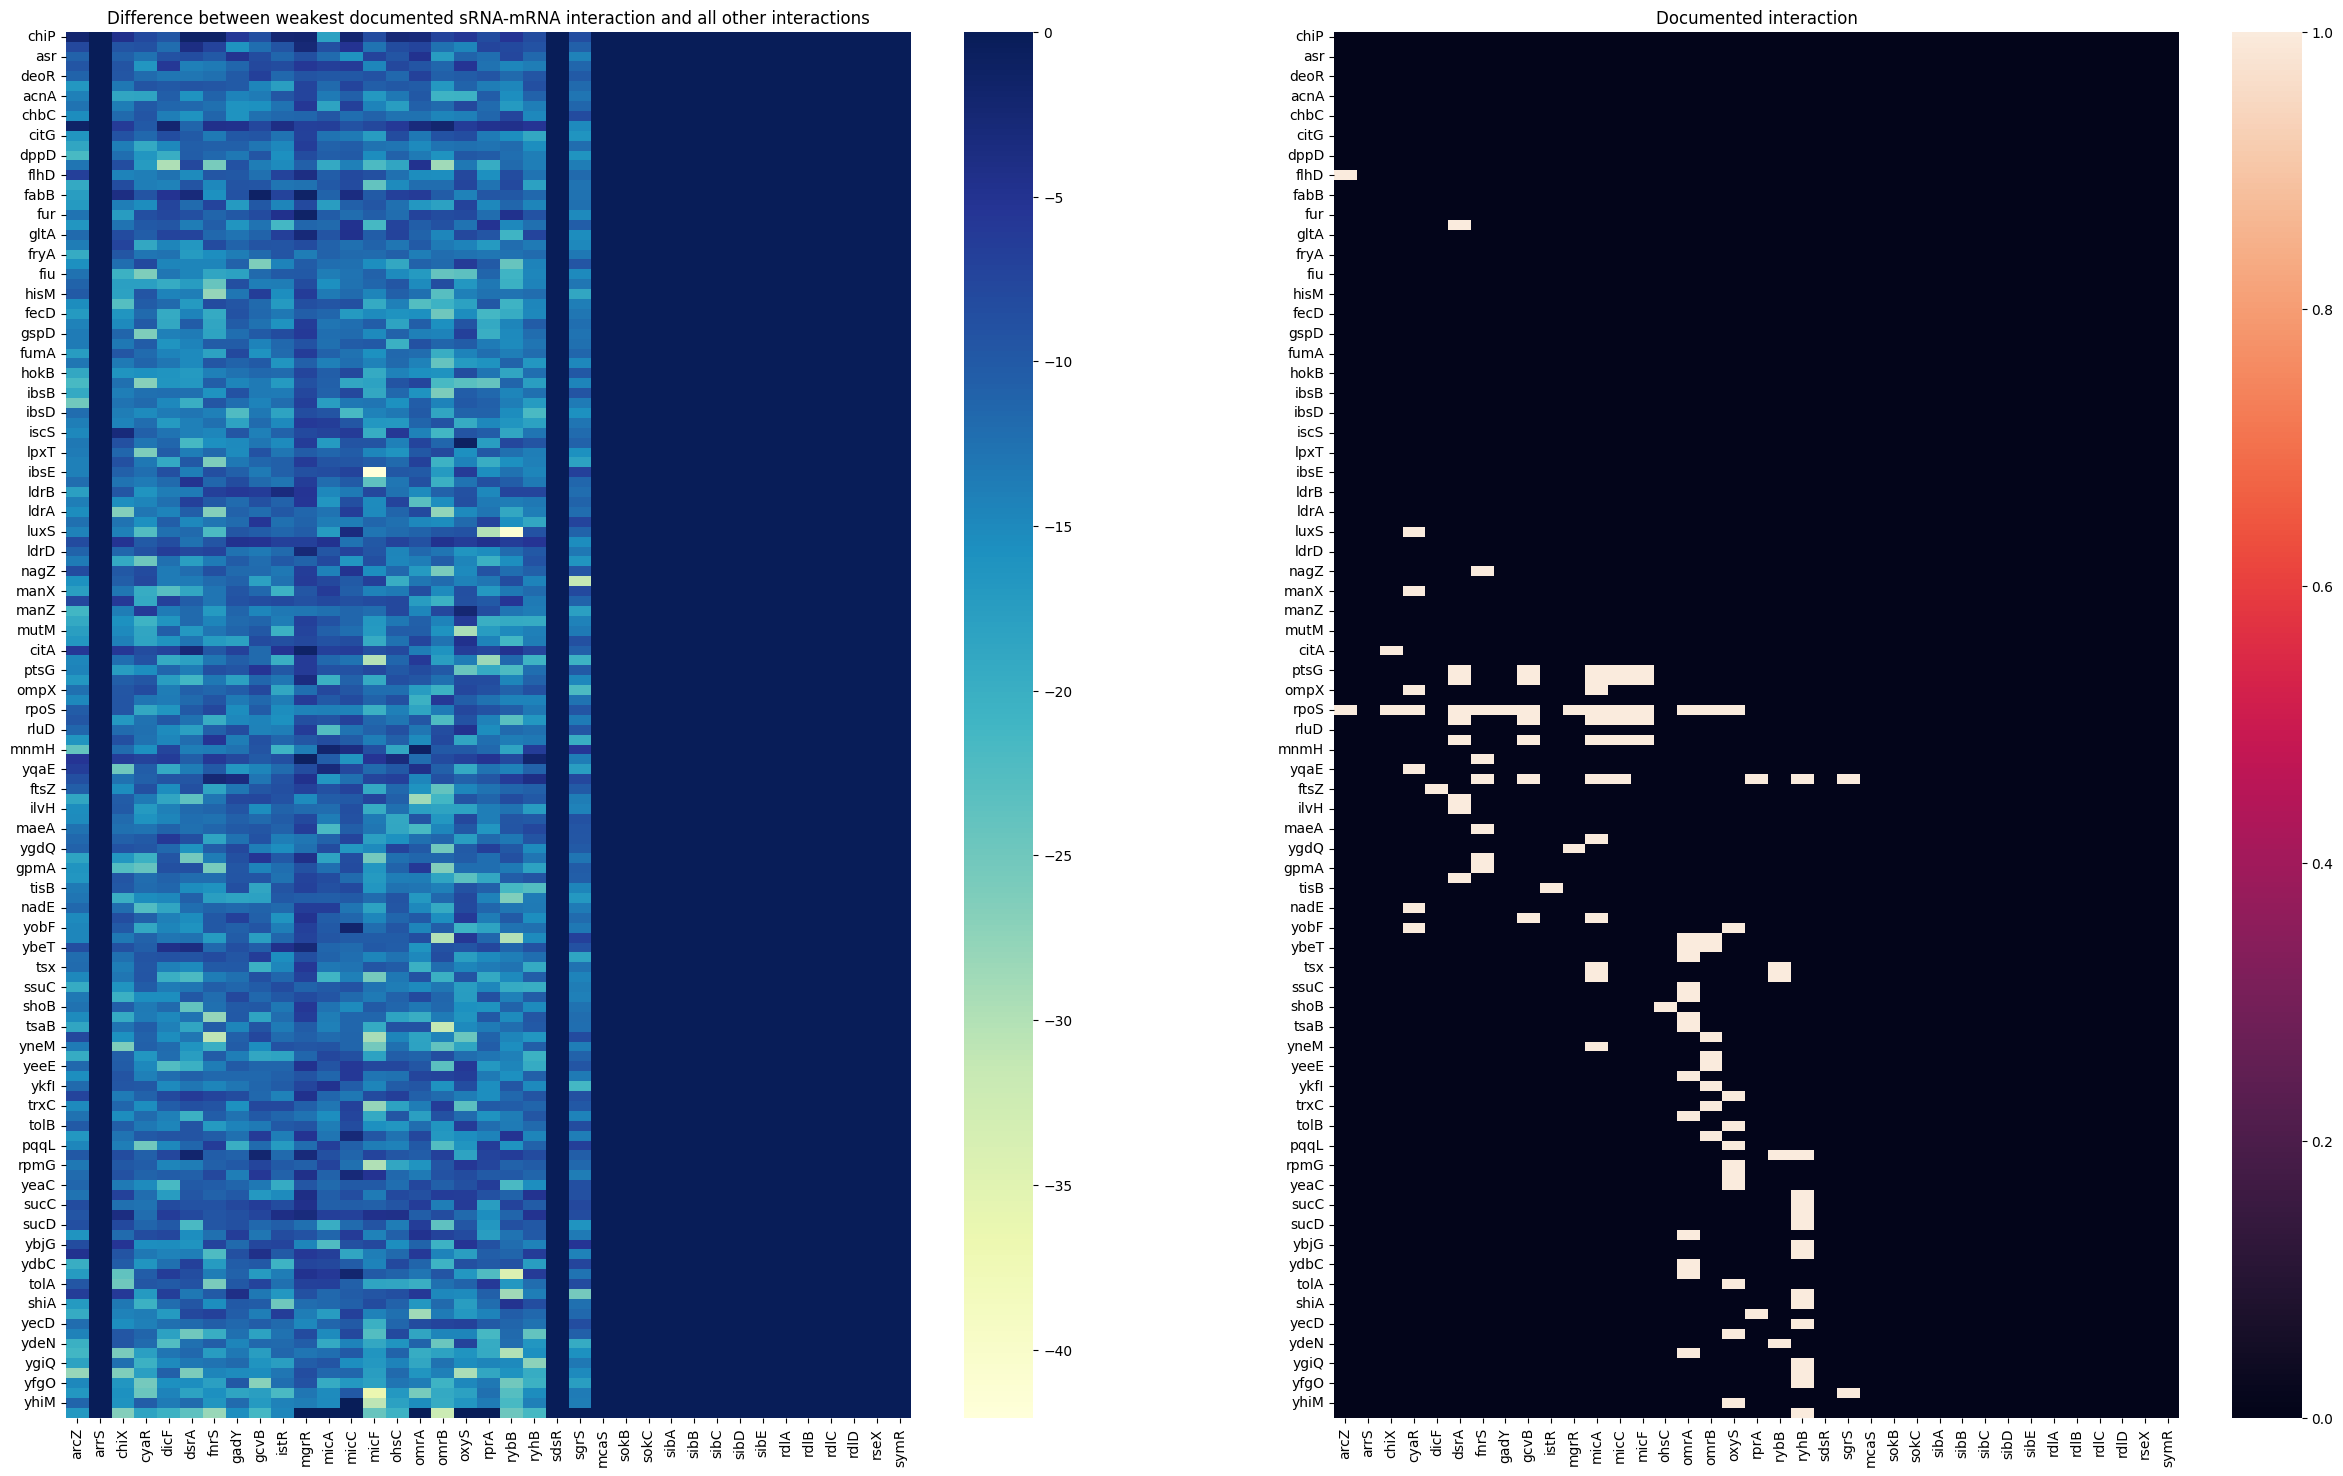

In [171]:
# threshold_binding_E = (specificity * energies).min(axis=0)
threshold_binding_E = np.where(specificity.sum(axis=0) > 0, (specificity * energies).max(axis=0), 0)

plt.figure(figsize=(30, 18))
ax = plt.subplot(1, 2, 1)
mask = (np.ones_like(energies) * (specificity.sum(axis=0) > 0).to_numpy()[None, :])
sns.heatmap(energies * mask - (
    np.ones_like(energies) * threshold_binding_E[None, :]), cmap='YlGnBu')
plt.title('Difference between weakest documented sRNA-mRNA interaction and all other interactions')

ax = plt.subplot(1, 2, 2)
sns.heatmap(specificity)
plt.title('Documented interaction')